An attempt at understanding the 2015 paper [Show and Tell: A neural image caption generator](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Vinyals_Show_and_Tell_2015_CVPR_paper.pdf) to learn more about pytorch and vision <-> language.

Dataset: Flickr8k and Flickr30k

In [26]:
import glob
import os
import matplotlib.pyplot as plt
import unicodedata
import string
import time
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T

In [5]:
DATASET_ROOT = '/Users/rohit/Desktop/datasets'
CAPTIONS_PATH = os.path.join(DATASET_ROOT, 'flickr8k/captions.txt')
IMAGES_PATH = os.path.join(DATASET_ROOT, 'flickr8k/images')

Let's go through the data and understand how to input it to the network

In [56]:
def get_captions(captions_file):
    """Returns a list of captions for the entire dataset"""

    captions = []

    with open(captions_file, 'r') as file:
        lines = file.readlines()

        for line in lines:
            parts = line.split(',', 1)
            parts = [part.strip() for part in parts]

            # Clean the label
            if '.jpg' not in parts[0]:
                print(f"Not an image caption line: {line}")
                continue
            
            parts[1] = parts[1].replace('"', '')
            captions.append(parts[1])

    return captions

all_captions = get_captions(CAPTIONS_PATH)

Not an image caption line: image,caption



In [60]:
word_frequency = {}
for caption in all_captions:
    words = caption.lower().split(" ")
    for word in words:
        if word in word_frequency:
            word_frequency[word] += 1
        else:
            word_frequency[word] = 1

print(f"Num words: {len(word_frequency)}")

Num words: 8918


Creating a custom dataset and dataloader

In [40]:
def splitDataset(captions_file, split_ratio:float = 0.8):
    """
    Splits the Flickr dataset into train and test splits

    Args:
        captions_file (str): filepath of the captions file
        split_ratio (float): ratio to split the captions

    Returns:
        train and test captions
    """
    with open(captions_file, 'r') as file:
        lines = file.readlines()

        total_lines = len(lines)
        split_point = int(total_lines * split_ratio)

        train_captions = lines[:split_point]
        test_captions = lines[split_point:]

        return train_captions, test_captions
            

class Flickr8kDataset(Dataset):
    def __init__(self, 
                captions, 
                images_folder, 
                transform=None,
                target_transform=None) -> None:
        self.captions = self.parseCaptions(captions)
        self.images_folder = images_folder
        self.transform = transform
        self.target_transform = target_transform
    
    def parseCaptions(self, captions):
        """Returns an array of array with image name and captions"""

        # we store as arrays of arrays ex. [[img1.jpg, "caption1"], [img2.jpg, "caption2"], ..]
        parsed_captions = []
        for line in captions:
            parts = line.split(',', 1)
            parts = [part.strip() for part in parts]

            # Clean the label
            if not '.jpg' or '.png' in parts[0]:
                print(f"Not an image caption line: {line}")
                continue
            
            parts[1] = parts[1].replace('"', '')
            parsed_captions.append([parts[0], parts[1]])

        return parsed_captions

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_folder, self.captions[idx][0])
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)

        caption = self.captions[idx][1]
        if self.target_transform:
            caption = self.target_transform(caption)
       
        return image, caption

train_captions, test_captions = splitDataset(CAPTIONS_PATH)

transforms = T.Compose([
                T.ToPILImage(),
                T.Resize((224, 224)),
                T.ToTensor()
            ])

train_data = Flickr8kDataset(train_captions, IMAGES_PATH, transforms)
test_data = Flickr8kDataset(test_captions, IMAGES_PATH, transforms)

print(f"Num training data: {len(train_data)}, num test data: {len(test_data)}")

Num training data: 32364, num test data: 8092


In [41]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Show some samples from the training set to verify if everything looks good

images batch shape: torch.Size([64, 3, 224, 224])
caption: Dog on a rock next to water .


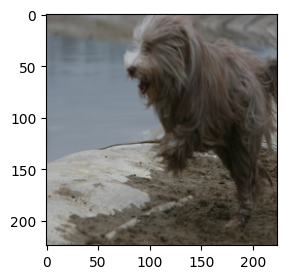

caption: Two black and two white dogs are playing in the snow .


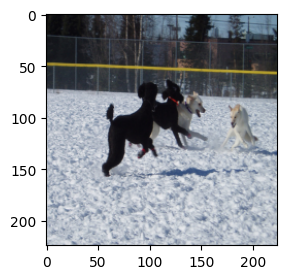

caption: A small boy is taking a black toy car from another small child .


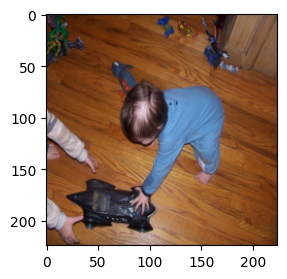

caption: A dog trying to catch a tennis ball .


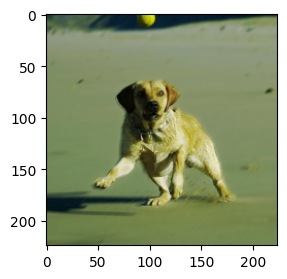

caption: A dog is in field on a very windy day with something in its mouth .


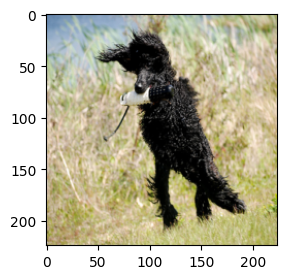

In [47]:
train_images, train_labels = next(iter(train_dataloader))
print(f"images batch shape: {train_images.shape}")

for i in range(5):
    image = train_images[i].permute(1, 2, 0).numpy()
    caption = train_labels[i]

    print(f"caption: {caption}")
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.show()